# Visualizando Isocronas em Python

esse tutorial apresenta uma metodologia para produzir e visualizar isocronas em Python
o codigo foi baseado nesse exemplo: https://github.com/gboeing/osmnx-examples/blob/master/notebooks/13-isolines-isochrones.ipynb  

uma documentacao reduzida e simples pode ser encontrada aqui: http://geoffboeing.com/2016/11/osmnx-python-street-networks/

## Carregando as Bibliotecas

In [37]:
import osmnx as ox, networkx as nx, geopandas as gpd, matplotlib.pyplot as plt
from shapely.geometry import Point, LineString, Polygon
from descartes import PolygonPatch
ox.config(log_console=True, use_cache=True)
%matplotlib inline  


## Configur o lugar, o tipo de rede, os tempos de viagem e a velocidade de viagem

In [38]:
# configure the place, network type, trip times, and travel speed
place = 'Rio de Janeiro, Brazil' #pode ser uma lista de cidades [Rio de Janeiro, Niteroi, Sao Joao de Meriti]

network_type = 'walk' #pode ser drive, drive_service, walk, bike, all, all_private
trip_times = [5, 10, 15, 20, 25] #em minutos
travel_speed = 4.5 #velocidade de caminhada em km/h

## Baixa e Prepara a rede de Ruas

In [39]:
# faz download da rede de ruras
G = ox.graph_from_place(place, network_type=network_type)

In [40]:
# projeta o grafo para UTM
gdf_nodes = ox.graph_to_gdfs(G, edges=False)

In [41]:
# encontra o no' mais proximo na rede
#x, y = gdf_nodes['geometry'].unary_union.centroid.xy #Aqui define o no de origem
x, y = [-43.188470,-22.912590] #Aqui define o no de origem
center_node = ox.get_nearest_node(G, (y, x)) 
G = ox.project_graph(G)

In [42]:
# adiciona um atributo de tempo em minutos aos links, referente ao tempo necessario para atravessa-lo
meters_per_minute = travel_speed * 1000 / 60 #km/h para metro/m
for u, v, k, data in G.edges(data=True, keys=True):
    data['time'] = data['length'] / meters_per_minute

## Plota os nós que podem ser acessados

In [43]:
# define uma cor para cada tempo
iso_colors = ox.get_colors(n=len(trip_times), cmap='Reds', start=0.3, return_hex=True)

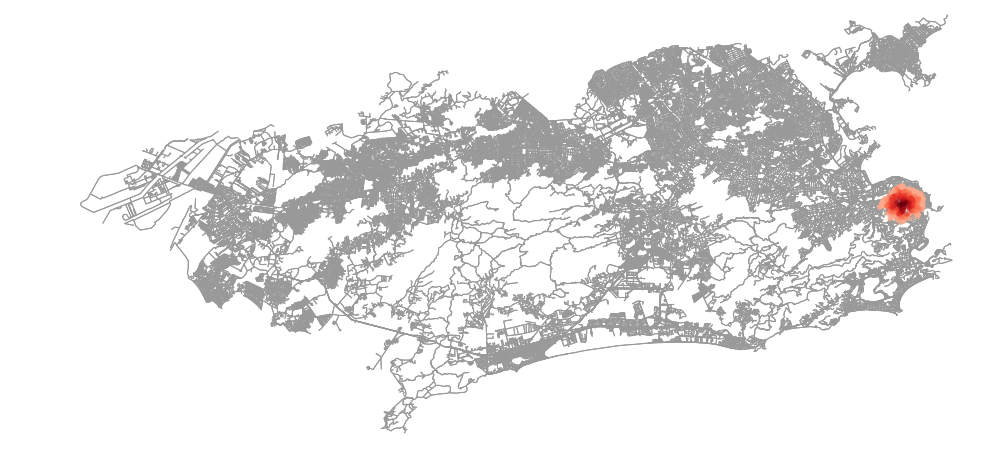

In [51]:
# color the nodes according to isochrone then plot the street network
node_colors = {}
for trip_time, color in zip(sorted(trip_times, reverse=True), iso_colors):
    subgraph = nx.ego_graph(G, center_node, radius=trip_time, distance='time')
    for node in subgraph.nodes():
        node_colors[node] = color
nc = [node_colors[node] if node in node_colors else 'none' for node in G.nodes()]
ns = [20 if node in node_colors else 0 for node in G.nodes()]
fig, ax = ox.plot_graph(G, fig_height=8, node_color=nc, node_size=ns, node_alpha=0.4, node_zorder=2)

## Plota as isocronas

In [45]:
# cria os poligonos
isochrone_polys = []
for trip_time in sorted(trip_times, reverse=True):
    subgraph = nx.ego_graph(G, center_node, radius=trip_time, distance='time')
    node_points = [Point((data['x'], data['y'])) for node, data in subgraph.nodes(data=True)]
    bounding_poly = gpd.GeoSeries(node_points).unary_union.convex_hull
    isochrone_polys.append(bounding_poly)

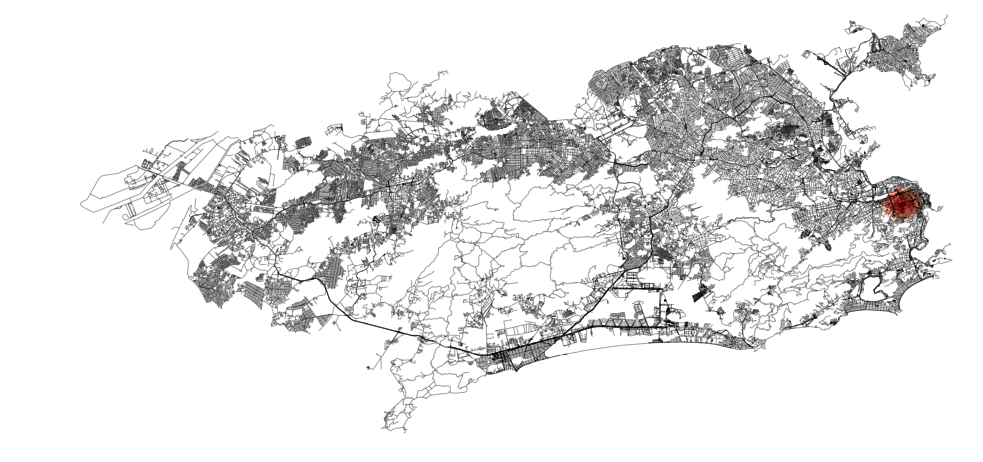

In [46]:
# plot the network then add isochrones as colored descartes polygon patches
fig, ax = ox.plot_graph(G, fig_height=8, show=False, close=False, edge_color='k', edge_alpha=0.2, node_color='none')
for polygon, fc in zip(isochrone_polys, iso_colors):
    patch = PolygonPatch(polygon, fc=fc, ec='none', alpha=0.6, zorder=-1)
    ax.add_patch(patch)
plt.show()

## Plota as isocronas como buffers dos pontos, para ter isocronas mais reais

In [47]:
#cria funcao que produz as isocronas a partir dos pontos

def make_iso_polys(G, edge_buff=25, node_buff=50, infill=False):
    isochrone_polys = []
    for trip_time in sorted(trip_times, reverse=True):
        subgraph = nx.ego_graph(G, center_node, radius=trip_time, distance='time')

        node_points = [Point((data['x'], data['y'])) for node, data in subgraph.nodes(data=True)]
        nodes_gdf = gpd.GeoDataFrame({'id': subgraph.nodes()}, geometry=node_points)
        nodes_gdf = nodes_gdf.set_index('id')

        edge_lines = []
        for n_fr, n_to in subgraph.edges():
            f = nodes_gdf.loc[n_fr].geometry
            t = nodes_gdf.loc[n_to].geometry
            edge_lines.append(LineString([f,t]))

        n = nodes_gdf.buffer(node_buff).geometry
        e = gpd.GeoSeries(edge_lines).buffer(edge_buff).geometry
        all_gs = list(n) + list(e)
        new_iso = gpd.GeoSeries(all_gs).unary_union
        
        # try to fill in surrounded areas so shapes will appear solid and blocks without white space inside them
        if infill:
            new_iso = Polygon(new_iso.exterior)
        isochrone_polys.append(new_iso)
    return isochrone_polys

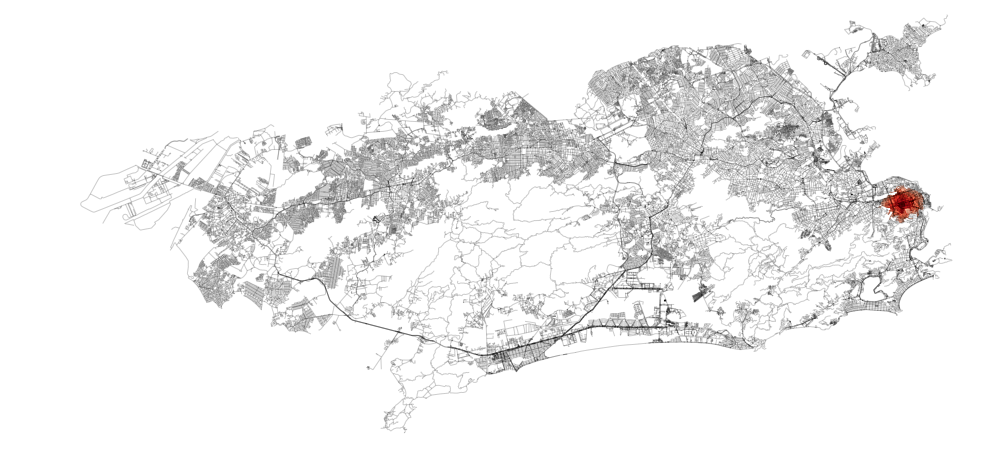

In [52]:
isochrone_polys = make_iso_polys(G, edge_buff=25, node_buff=0, infill=True)
fig, ax = ox.plot_graph(G, fig_height=8, show=False, close=False, edge_color='k', edge_alpha=0.1, node_color='none')
for polygon, fc in zip(isochrone_polys, iso_colors):
    patch = PolygonPatch(polygon, fc=fc, ec='none', alpha=0.99, zorder=-1)
    ax.add_patch(patch)
plt.show()